Most exchanged bugs. re: Rachel's email

> I think it is really important to highlight the most commonly exchanged bacteria between the three sights in aspirating patients compared to nonaspirating patients. Clinically this is important and is especially important as all of us are looking for biomarkers of aspiration or biomarkers of more significant lung disease of which bacterial may be one….    

Two ways to answer this:

1. Which OTUs are ``most exchanged'' between throat and lungs, in general? (Sort of boring, but easiest to answer).
2. Of the BAL-throat exchanged OTUs, which are most differentially abundant/prevalent between aspirators and non-aspirators?
    - not sure if prevalence or abundance is more interesting. probably prevalence, since we're looking for a clinically relevant biomarker...
    
In this notebook, I also try to build classifiers based only on the most exchanged OTUs.

2018-01-16 update: I'm going to do all the same analyses, but for the lung-stomach bugs too.

In [1]:
import pandas as pd

from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [32]:
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import confusion_matrix, auc, roc_curve
from scipy import interp
from scipy.stats import fisher_exact

def cv_and_roc(rf, X, Y, num_cv=5, random_state=None, shuffle=False):
    """
    Perform cross validated training and testing and return the aggregate
    interpolated ROC curve and confusion matrices.

    Parameters
    ----------
    rf : any sklearn classifier object
    X : array-like or sparse matrix, shape = [n_samples, n_features]
        The input samples to be split into train and test folds and
        cross-validated.
    Y : list or array
        array-like, shape = [n_samples] or [n_samples, n_outputs]
        The target values (class labels in classification).
    num_cv : int (default: 5)
        number of cross-validation folds
    random_state : int (default 12345)
        random state seed for StratifiedKFold

    Returns
    -------
    d : dict with the following keys:
        'roc_auc': area under the ROC curve
        'conf_mat': confusion matrix array, looks like:
                              pred
                             0   1
                    true  0  -   -
                          1  -   -
        'fisher_p': fisher exact pvalue of conf_mat above
        'y_probs': probability of being class 1
        'y_trues': true labels
        'mean_fpr', 'mean_tpr': interpolated values used to build ROC curve

    """
    if isinstance(Y, list):
        Y = np.asarray(Y)
    cv = StratifiedKFold(Y, num_cv, shuffle=True, random_state=random_state)
    tpr_list = []
    auc_list = []
    mean_fpr = np.linspace(0, 1, 100)
    conf_mat = np.asarray([[0,0],[0,0]])
    y_probs = np.empty_like(Y)
    y_predictions = np.empty_like(Y)

    for train_index, test_index in cv:
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        probs = rf.fit(X_train, Y_train).predict_proba(X_test)[:,1]
        preds = rf.predict(X_test)

        # Store probability and predicted values for X_test
        y_probs[test_index] = probs
        y_predictions[test_index] = preds

        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(Y_test, probs)
        roc_auc = auc(fpr, tpr)
        auc_list.append(roc_auc)
        tpr_list.append(interp(mean_fpr, fpr, tpr))
        tpr_list[-1][0] = 0.0

        # Compute confusion matrix
        conf_mat += confusion_matrix(Y_test, preds, labels=[0,1])

    # Get fisher p value, sensitivity/specificity, positive/negative pred value
    _, fisher_p = fisher_exact(conf_mat)
    # conf_mat: rows are the true labels, columns are the predicted labels
    conf_mat = pd.DataFrame(conf_mat)
    conf_mat.columns = ['pred 0', 'pred 1']
    conf_mat.index = ['true 0', 'true 1']
    ppv = conf_mat.loc['true 1', 'pred 1'] / float(conf_mat['pred 1'].sum())
    npv = conf_mat.loc['true 0', 'pred 0'] / float(conf_mat['pred 0'].sum())
    spec = \
        conf_mat.loc['true 0', 'pred 0'] / float(conf_mat.loc['true 0'].sum())
    sens = \
        conf_mat.loc['true 1', 'pred 1'] / float(conf_mat.loc['true 1'].sum())

    return {i: j for i, j in
            zip(('auc_list', 'conf_mat', 'mean_fpr', 'tpr_list',
                'fisher_p', 'y_prob', 'y_predictions', 'y_true',
                'sensitivity', 'specificity', 'ppv', 'npv'),
               (auc_list, conf_mat, mean_fpr, tpr_list, fisher_p,
               y_probs, y_predictions, Y,
               sens, spec, ppv, npv))}

def plot_auc_from_list(tpr_list, mean_fpr, color='blue', ax=None):
    """ 
    tpr_list : list
        list of true positive rates (len(tpr_list) = number of CV folds)
    mean_fpr : list
        np.linspace(0, 1) with the same number of elements as tpr_list
    color : str
        color of the mean ROC line to plot
    
    Adapted from Isaac's code at 
    https://github.com/irockafe/revo_healthcare/blob/master/src/visualization/viz.py
    """
    # get mean tpr and fpr
    mean_tpr = np.mean(tpr_list, axis=0)
    # make sure it ends up at 1.0
    mean_tpr[-1] = 1.0
    
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(mean_fpr, mean_tpr, color=color)
    # Plot luck line
    ax.plot([0, 1], [0, 1], linestyle='--', color='k', alpha=0.5)
    
    # plot 1-std
    std_tpr = np.std(tpr_list, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=color,
                    alpha=0.2)
    
    return ax

def tidyfy_otu(df, meta, mbscol):
    """
    Turn OTU table into a tidy dataframe with subject, sample ID, site, OTU,
    OTU labeled with the site, abundance, and aspiration status.

    To make our OTU-based classifiers (after tidyfying), we will:
    1. Query tidyotu for the site(s) of interest and drop any samples
       without aspiration metadata.
    2. Pivot queried table to have subjects in rows and otu-w-site in columns
    3. Assemble the output (Y) from the metadata, using a subject to
       aspiration status dict

    Parameters
    ----------
    df : pandas DataFrame
        OTUs in columns and samples in rows
    meta : pandas DataFrame
        metadata in columns and samples in rows
    mbscol : str
        column in meta with aspiration status
    """
    
    print('Tidying data... ')
    tidyotu = pd.melt(df.reset_index(), id_vars='index', value_name='abun',
                      var_name='otu')
    tidyotu = tidyotu.rename(columns={'index': 'sample'})
    # Add the subject ID, site, and aspiration metadata associated with each sample
    keepcols = [mbscol, 'site', 'subject_id']
    tidyotu = tidyotu.merge(meta[keepcols], left_on='sample', right_index=True)
    # Label OTUs with their associated site
    tidyotu['otu_w_site'] = tidyotu.apply(
        lambda row: row['otu'] + '--' + row['site'],
        axis=1)
    print('Finished.')
    return tidyotu

def convert_to_latex(row):
    """
    Convert a row from a pandas DataFrame (i.e. a Series)
    into different cells in a Latex table. Also replaces
    underscores with escaped underscore.
    """
    return ' & '.join(['\_'.join(i.split('_')) for i in row.astype(str)]) + ' \\\ '


In [2]:
fexchange = '../../data/analysis/exchange.with_partial_corrs.txt'
df = pd.read_csv(fexchange, sep='\t')
df.head()

,otu,site1,site2,site3,r_site12,p_site12,n_site12,r_partial,p_partial,n_partial,shuffled
0,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo259,gastric_fluid,throat_swab,bal,0.538462,0.057634,13,0.527205,0.0455,10,False
1,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo364,bal,gastric_fluid,throat_swab,0.633498,0.000225,29,0.630829,0.0000,21,False
2,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo364,gastric_fluid,throat_swab,bal,0.500000,0.253170,7,0.494496,0.1620,5,False
3,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,bal,gastric_fluid,throat_swab,0.142857,0.787172,6,NaN,NaN,4,False
4,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,gastric_fluid,throat_swab,bal,0.657143,0.156175,6,NaN,NaN,1,False


# Which are the most exchanged OTUs?

First: look at which ones have the highest correlation between two sites. 

But the thing I really want is the ones that have the highest prevalence in both sites. These are the "most exchanged." That said, the thing I'll actually report is the most differentially exchanged bugs (see section below).

In [3]:
n_thresh = 10
df = df.query('n_partial >= @n_thresh')
df['genus'] = df['otu'].str.split(';').str[-3]

In [127]:
## Show the OTUs with the largest r_partial
#sites = ['bal', 'gastric_fluid', 'throat_swab']
#cols = ['otu', 'site1', 'site2', 'r_partial', 'p_partial', 'n_partial', 'genus']
#for site1 in sites:
#    for site2 in sites[sites.index(site1)+1:]:
#        print(site1, site2)
#        display(df\
#                .dropna(subset=['r_partial'])\
#                .query('site1 == @site1')\
#                .query('site2 == @site2')\
#                .sort_values(by=['r_partial', 'p_partial'], ascending=[False, True])\
#                [cols]\
#                .head(10))

# What are the most differentially exchanged OTUs?

Which of the throat-BAL OTUs are most differentially prevalent between aspirators and non-aspirators? 
Then: what are their average abundances in throats and lungs of aspirators/non-aspirators?

In [131]:
fpreva = '../../data/analysis/prevalence.partial_corrs.nthresh10-qthresh01-rthresh0.txt'
preva = pd.read_csv(fpreva, sep='\t')
preva.head()

,otu,prevalence_exchange,meta_var,meta_val,site_comparison,n_patients
0,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo364,0.237705,all_patients,all_patients,bal-gastric_fluid,122
1,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.147541,all_patients,all_patients,bal-gastric_fluid,122
2,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.139344,all_patients,all_patients,bal-gastric_fluid,122
3,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.393443,all_patients,all_patients,bal-gastric_fluid,122
4,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.180328,all_patients,all_patients,bal-gastric_fluid,122


In [132]:
# Number of exchange OTUs per site combination
preva.query('meta_var == "all_patients"').groupby('site_comparison').size()

site_comparison
bal-gastric_fluid            48
bal-throat_swab               9
gastric_fluid-throat_swab    98
dtype: int64

In [133]:
#preva['meta_var'].unique()

In [134]:
# Let's look just at the aspirator vs. non-aspirator comparisons
preva = preva.query('meta_var == "mbs_consolidated"')

# And just the bal-throat_swab comparison
preva = preva.query('site_comparison == "bal-throat_swab"')

In [135]:
#print(preva['meta_val'].unique())
#print(preva['site_comparison'].unique())

In [136]:
#print(preva.shape, preva['otu'].unique().shape)

In [137]:
diffpreva = preva.pivot(index='otu', columns='meta_val', values='prevalence_exchange')
diffpreva['asp_minus_nml'] = diffpreva['Aspiration/Penetration'] - diffpreva['Normal']
diffpreva['abs_diff'] = abs(diffpreva['asp_minus_nml'])

In [138]:
diffpreva.sort_values(by='abs_diff', ascending=False)

meta_val,Aspiration/Penetration,Normal,asp_minus_nml,abs_diff
otu,,,,
k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__;s__;d__denovo93,0.428571,0.066667,0.361905,0.361905
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__;d__denovo8,0.642857,0.300000,0.342857,0.342857
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__;d__denovo13,0.678571,0.366667,0.311905,0.311905
k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Veillonellaceae;g__Veillonella;s__;d__denovo26,0.571429,0.266667,0.304762,0.304762
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__;d__denovo323,0.392857,0.133333,0.259524,0.259524
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__;d__denovo100,0.321429,0.100000,0.221429,0.221429
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__;d__denovo213,0.321429,0.133333,0.188095,0.188095
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__;d__denovo287,0.178571,0.100000,0.078571,0.078571
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__;s__;d__denovo37,0.321429,0.366667,-0.045238,0.045238


In [139]:
# Just as a reminder... how many patients were used for these prevalence calcs?
preva[['meta_val', 'n_patients']].drop_duplicates()

,meta_val,n_patients
825,Aspiration/Penetration,28
834,Normal,30


Note: I could just include this table, I think it's pretty interesting on its own right. For the paper, we'll have family and genus level indicators, prevalence in aspirators, prevalence in normal, and differential prevalence.

In [166]:
## Do some text manipulations to print these values out in latex table format

# Split OTU names to individual phyla
table = pd.concat((diffpreva.reset_index(), diffpreva.reset_index()['otu'].str.split(';', expand=True)), axis=1)
table['family'] = table[4].str.split('f__').str[1]
table['genus'] = table[5].str.split('g__').str[1]
# Re-format percentages
table['Aspiration/Penetration'] = table['Aspiration/Penetration'].apply(lambda x: '{:.1f}'.format(x*100))
table['Normal'] = table['Normal'].apply(lambda x: '{:.1f}'.format(x*100))
table['Difference'] = table['asp_minus_nml'].apply(lambda x: '{:.1f}'.format(x*100))
table = table.sort_values(by='asp_minus_nml', ascending=False)

col_order = ['family', 'genus', 'Aspiration/Penetration', 'Normal', 'Difference']
table = table[col_order]
print('\n'.join(table.apply(convert_to_latex, axis=1)))

Flavobacteriaceae &  & 42.9 & 6.7 & 36.2 \\ 
Fusobacteriaceae & Fusobacterium & 64.3 & 30.0 & 34.3 \\ 
Porphyromonadaceae & Porphyromonas & 67.9 & 36.7 & 31.2 \\ 
Veillonellaceae & Veillonella & 57.1 & 26.7 & 30.5 \\ 
Streptococcaceae & Streptococcus & 39.3 & 13.3 & 26.0 \\ 
Fusobacteriaceae & Fusobacterium & 32.1 & 10.0 & 22.1 \\ 
Prevotellaceae & Prevotella & 32.1 & 13.3 & 18.8 \\ 
Porphyromonadaceae & Porphyromonas & 17.9 & 10.0 & 7.9 \\ 
Pasteurellaceae &  & 32.1 & 36.7 & -4.5 \\ 


# Classify aspirator from non-aspirator with throat-BAL OTUs

In [102]:
fotu = '../../data/clean/rosen.otu_table.rel_abun.clean'
fmeta = '../../data/clean/rosen.metadata.clean'

otu = pd.read_csv(fotu, sep='\t', index_col=0)
meta = pd.read_csv(fmeta, sep='\t', index_col=0)

In [103]:
keepotus = diffpreva.index.tolist()
otu = otu[keepotus]

In [104]:
# Grab patients with both BAL and throat swab, and aspiration status
sites = ['bal', 'throat_swab']
patientsamples = meta\
    .query('site == @sites')\
    .dropna(subset=['mbs_consolidated'])\
    .groupby(['mbs_consolidated', 'site', 'subject_id'])\
    .size()\
    .to_frame('n_samples')\
    .reset_index()\
    .groupby(['subject_id', 'mbs_consolidated'])\
    .size()\
    .to_frame('n_samples')\
    .reset_index()
patientsamples = patientsamples.query('n_samples == 2')
#patientsamples.head()

,subject_id,mbs_consolidated,n_samples
0,02-096-6,Normal,2
1,02-098-5,Normal,2
2,02-111-4,Normal,2
3,02-120-4,Normal,2
7,02-186-0,Aspiration/Penetration,2


In [105]:
h_subjs = patientsamples.query('mbs_consolidated == "Normal"')['subject_id'].tolist()
asp_subjs = patientsamples.query('mbs_consolidated == "Aspiration/Penetration"')['subject_id'].tolist()

### Asp vs. non-asp, using BAL samples and bal-throat exchanged OTUs only

In [33]:
h_smpls = meta.query('subject_id == @h_subjs').query('site == "bal"').index.tolist()
asp_smpls = meta.query('subject_id == @asp_subjs').query('site == "bal"').index.tolist()

aspdict = {'Normal': 0, 'Aspiration/Penetration': 1}

X = otu.loc[h_smpls + asp_smpls, :]
Y = [aspdict[meta.loc[i, 'mbs_consolidated']] for i in X.index]
X = X.values

In [34]:
# BAL samples only, bal-throat OTUs only
rf = RandomForestClassifier(n_estimators=1000)
random_state=1234

results = cv_and_roc(rf, X, Y, random_state=random_state)

In [30]:
np.mean(results['auc_list'])

0.59045539570792094

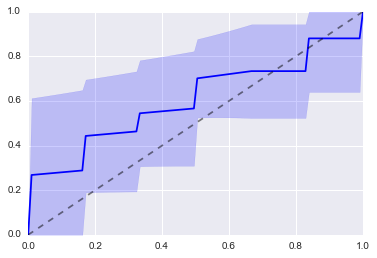

In [39]:
plot_auc_from_list(results['tpr_list'], results['mean_fpr'])

In [40]:
print(fisher_exact(results['conf_mat']))
results['conf_mat']

,pred 0,pred 1
true 0,17,13
true 1,14,14


### Asp vs. non-asp, using throat samples and bal-throat exchanged OTUs only

In [41]:
# Throat samples only, bal-throat OTUs only
h_smpls = meta.query('subject_id == @h_subjs').query('site == "throat_swab"').index.tolist()
asp_smpls = meta.query('subject_id == @asp_subjs').query('site == "throat_swab"').index.tolist()

X = otu.loc[h_smpls + asp_smpls, :]
Y = [aspdict[meta.loc[i, 'mbs_consolidated']] for i in X.index]
X = X.values

rf = RandomForestClassifier(n_estimators=1000)
results = cv_and_roc(rf, X, Y, random_state=random_state)

In [42]:
np.mean(results['auc_list'])

0.55888888888888888

In [43]:
print(fisher_exact(results['conf_mat']))
results['conf_mat']

,pred 0,pred 1
true 0,19,11
true 1,15,13


### How about presence/absence?

In [45]:
X_pres = (X > 0).astype(int)
rf = RandomForestClassifier(n_estimators=1000)

results = cv_and_roc(rf, X_pres, Y, random_state=random_state)

In [47]:
np.mean(results['auc_list'])

0.45944444444444449

In [48]:
print(fisher_exact(results['conf_mat']))
results['conf_mat']

,pred 0,pred 1
true 0,15,15
true 1,18,10


### Asp vs. non-asp, using BAL and throat samples, and bal-throat exchanged OTUs only

In [106]:
mbscol = 'mbs_consolidated'
tidyotu = tidyfy_otu(otu, meta, mbscol)

site1 = 'bal'
site2 = 'throat_swab'
tmpotu = tidyotu.query('(site == @site1) | (site == @site2)')\
            .dropna(subset=[mbscol])\
            .pivot(index='subject_id', columns='otu_w_site',
                   values='abun')\
            .dropna()

Tidying data... 
Finished.


In [107]:
tmpotu.shape

(58, 18)

In [110]:
tmpotu.tail()

otu_w_site,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__;d__denovo13--bal,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__;d__denovo13--throat_swab,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__;d__denovo287--bal,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__;d__denovo287--throat_swab,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__;d__denovo213--bal,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__;d__denovo213--throat_swab,k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__;s__;d__denovo93--bal,k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__;s__;d__denovo93--throat_swab,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__;d__denovo323--bal,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__;d__denovo323--throat_swab,k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Veillonellaceae;g__Veillonella;s__;d__denovo26--bal,k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Veillonellaceae;g__Veillonella;s__;d__denovo26--throat_swab,k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__;d__denovo100--bal,k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__;d__denovo100--throat_swab,k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__;d__denovo8--bal,k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__;d__denovo8--throat_swab,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__;s__;d__denovo37--bal,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__;s__;d__denovo37--throat_swab
subject_id,,,,,,,,,,,,,,,,,,
13-110-5,0.000000,0.077922,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000072,0.000000,0.058486,0.000000,0.000000,0.000000,0.040843,0.000000,0.000108
13-115-1,0.000043,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000033,0.000000,0.000366,0.000000,0.000000,0.000000,0.000167,0.000129,0.000000
13-117-4,0.000000,0.069247,0.00000,0.000000,0.0,0.000000,0.0,0.001055,0.000000,0.000000,0.000000,0.025692,0.000000,0.000000,0.002834,0.098102,0.000000,0.000895
14-111-4,0.000000,0.007481,0.00000,0.000000,0.0,0.000033,0.0,0.000132,0.000000,0.000033,0.000000,0.005925,0.000000,0.000099,0.000000,0.047931,0.000000,0.001523
14-165-8,0.048408,0.064032,0.00151,0.000262,0.0,0.000000,0.0,0.000000,0.000189,0.000000,0.045648,0.052473,0.000377,0.000000,0.036329,0.071535,0.008092,0.000349


In [111]:
# Note: using how='inner' preserves the order of the left keys, so this new tmpmeta
# is in the same order as my OTU table
tmpmeta = pd.merge(tmpotu, meta[['subject_id', 'mbs_consolidated']].drop_duplicates(),  
                   left_index=True, right_on='subject_id',
                   how='inner')
tmpmeta.tail()

,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__;d__denovo13--bal,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__;d__denovo13--throat_swab,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__;d__denovo287--bal,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas;s__;d__denovo287--throat_swab,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__;d__denovo213--bal,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__;d__denovo213--throat_swab,k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__;s__;d__denovo93--bal,k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__;s__;d__denovo93--throat_swab,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__;d__denovo323--bal,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__;d__denovo323--throat_swab,k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Veillonellaceae;g__Veillonella;s__;d__denovo26--bal,k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Veillonellaceae;g__Veillonella;s__;d__denovo26--throat_swab,k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__;d__denovo100--bal,k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__;d__denovo100--throat_swab,k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__;d__denovo8--bal,k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__;d__denovo8--throat_swab,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__;s__;d__denovo37--bal,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__;s__;d__denovo37--throat_swab,subject_id,mbs_consolidated
13-110-5B,0.000000,0.077922,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000072,0.000000,0.058486,0.000000,0.000000,0.000000,0.040843,0.000000,0.000108,13-110-5,Normal
13-115-1B,0.000043,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000033,0.000000,0.000366,0.000000,0.000000,0.000000,0.000167,0.000129,0.000000,13-115-1,Normal
13-117-4B,0.000000,0.069247,0.00000,0.000000,0.0,0.000000,0.0,0.001055,0.000000,0.000000,0.000000,0.025692,0.000000,0.000000,0.002834,0.098102,0.000000,0.000895,13-117-4,Aspiration/Penetration
14-111-4B,0.000000,0.007481,0.00000,0.000000,0.0,0.000033,0.0,0.000132,0.000000,0.000033,0.000000,0.005925,0.000000,0.000099,0.000000,0.047931,0.000000,0.001523,14-111-4,Normal
14-165-8B,0.048408,0.064032,0.00151,0.000262,0.0,0.000000,0.0,0.000000,0.000189,0.000000,0.045648,0.052473,0.000377,0.000000,0.036329,0.071535,0.008092,0.000349,14-165-8,Normal


In [119]:
tmpotu.index == tmpmeta['subject_id'].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True], dtype=bool)

In [112]:
X = tmpotu.values
Y = [aspdict[i] for i in tmpmeta['mbs_consolidated']]

In [113]:
tmpotu.shape

(58, 18)

In [114]:
meta[['subject_id', 'mbs_consolidated']].drop_duplicates().shape

(260, 2)

In [115]:
rf = RandomForestClassifier(n_estimators=1000)
results_balthr = cv_and_roc(rf, X, Y, random_state=random_state)

In [116]:
np.mean(results_balthr['auc_list'])

0.51444444444444448

In [117]:
results_balthr['conf_mat']

,pred 0,pred 1
true 0,21,9
true 1,17,11


### How about presence/absence classifiers?

In [59]:
X_pres = (X > 0).astype(int)

rf = RandomForestClassifier(n_estimators=1000)

results_balthr = cv_and_roc(rf, X_pres, Y, random_state=random_state)

In [60]:
np.mean(results_balthr['auc_list'])

0.57611111111111113

In [61]:
results_balthr['conf_mat']

,pred 0,pred 1
true 0,16,14
true 1,15,13


# What do the bal-throat OTUs look like in the two sites?

In [62]:
tidyotu.head()

,sample,otu,abun,mbs_consolidated,site,subject_id,otu_w_site
0,01-112-7GI,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,0.000007,NaN,gastric_fluid,01-112-7,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...
628,01-112-7GI,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,0.000000,NaN,gastric_fluid,01-112-7,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...
1256,01-112-7GI,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,0.000000,NaN,gastric_fluid,01-112-7,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...
1884,01-112-7GI,k__Bacteria;p__Bacteroidetes;c__Flavobacteriia...,0.000004,NaN,gastric_fluid,01-112-7,k__Bacteria;p__Bacteroidetes;c__Flavobacteriia...
2512,01-112-7GI,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,0.000000,NaN,gastric_fluid,01-112-7,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...


In [63]:
keepsites = ['bal', 'throat_swab']
tmp = tidyotu\
    .query('otu == @keepotus')\
    .query('(subject_id == @h_subjs) | (subject_id == @asp_subjs)')\
    .query('site == @keepsites')
tmp['log_abun'] = np.log10(tmp['abun'] + 1e-6)


/Users/claire/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/Users/claire/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


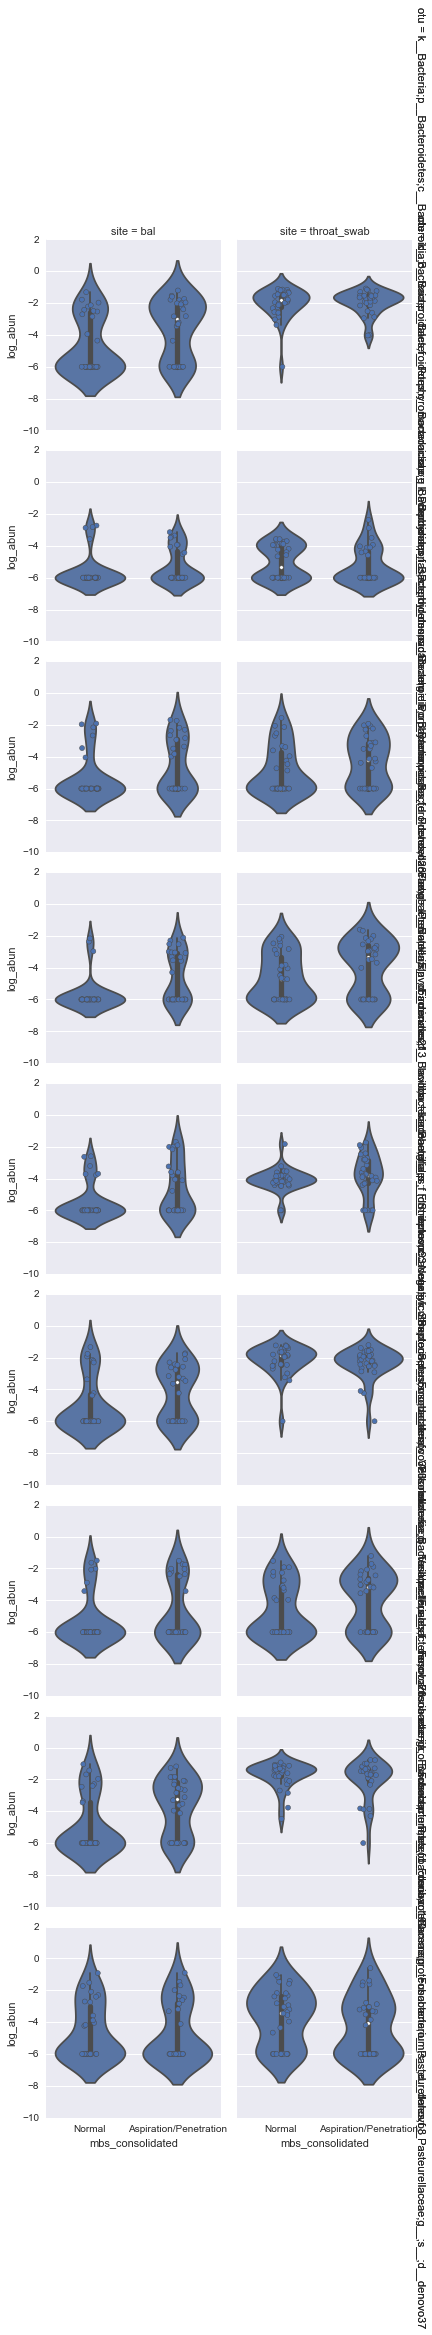

In [64]:
g = sns.FacetGrid(col='site', row='otu', data=tmp, margin_titles=True)
g.map(sns.violinplot, 'mbs_consolidated', 'log_abun')
g.map(sns.stripplot, 'mbs_consolidated', 'log_abun', jitter=True, split=True, linewidth=0.5)

Okay, so the lungs are definitely more informative than the throat (obvs). 

Might be worth just presenting these results as potential bugs to follow up with for biomarker
studies?? 

That said, these are really bimodal results... I do want to try the presence/absence classifier!
And maybe I should try something simpler than Random Forest...?

2018-01-16 follow-up - just present these negative results as negative results. No worries!

# Gastric-BAL OTUs

Basically repeat all the classifiers on the gastric and BAL exchange OTUs

In [167]:
## First, look at the most differentially exchange bugs
fpreva = '../../data/analysis/prevalence.partial_corrs.nthresh10-qthresh01-rthresh0.txt'
preva = pd.read_csv(fpreva, sep='\t')

# Let's look just at the aspirator vs. non-aspirator comparisons
preva = preva.query('meta_var == "mbs_consolidated"')

# And just the bal-throat_swab comparison
preva = preva.query('site_comparison == "bal-gastric_fluid"')

print(preva.shape, preva['otu'].unique().shape)

# Pivot to get differential prevalence
diffpreva = preva.pivot(index='otu', columns='meta_val', values='prevalence_exchange')

# Sort values by differential prevalence in aspirators
diffpreva['asp_minus_nml'] = diffpreva['Aspiration/Penetration'] - diffpreva['Normal']
#diffpreva['abs_diff'] = abs(diffpreva['asp_minus_nml'])
diffpreva.sort_values(by='asp_minus_nml', ascending=False).head(10)

((96, 6), (48,))


meta_val,Aspiration/Penetration,Normal,asp_minus_nml
otu,,,
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus;s__;d__denovo3,0.78125,0.439024,0.342226
k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria;s__;d__denovo124,0.37500,0.048780,0.326220
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus;s__;d__denovo216,0.34375,0.073171,0.270579
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus;s__;d__denovo7,0.78125,0.512195,0.269055
k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria;s__;d__denovo5,0.75000,0.487805,0.262195
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__;s__;d__denovo10,0.65625,0.414634,0.241616
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__;d__denovo17,0.59375,0.365854,0.227896
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__;d__denovo18,0.53125,0.317073,0.214177
k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__;d__denovo8,0.59375,0.390244,0.203506


In [168]:
# Just as a reminder... how many patients were used for these prevalence calcs?
preva[['meta_val', 'n_patients']].drop_duplicates()

,meta_val,n_patients
48,Aspiration/Penetration,32
96,Normal,41


For the paper, I'll just show these in the supplement.

In [197]:
## Do some text manipulations to print these values out in latex table format
table = pd.concat((diffpreva.reset_index(), diffpreva.reset_index()['otu'].str.split(';', expand=True)), axis=1)

# Split OTU names to individual phyla
# Prettify results
table['family'] = table[4].str.split('f__').str[1]
table['genus'] = table[5].str.split('g__').str[1]

# Fill in empty families with order
table['family'] = table['family'].where(table['family'] != '', "Unknown " + table[3].str.split('o__').str[1])
# Fill in empty orders with "Unkown bacteria" (I checked manually that this one is unannotated all the way)
table['family'] = table['family'].where(table['family'] != 'Unknown ', "Unknown Bacteria")

# Re-format percentages
table['Aspiration/Penetration'] = table['Aspiration/Penetration'].apply(lambda x: '{:.1f}'.format(x*100))
table['Normal'] = table['Normal'].apply(lambda x: '{:.1f}'.format(x*100))
table['Difference'] = table['asp_minus_nml'].apply(lambda x: '{:.1f}'.format(x*100))

table = table.sort_values(by='asp_minus_nml', ascending=False)

col_order = ['family', 'genus', 'Aspiration/Penetration', 'Normal', 'Difference']
table = table[col_order]
print('\n'.join(table.apply(convert_to_latex, axis=1)))

Pasteurellaceae & Haemophilus & 78.1 & 43.9 & 34.2 \\ 
Neisseriaceae & Neisseria & 37.5 & 4.9 & 32.6 \\ 
Lachnospiraceae & Coprococcus & 34.4 & 7.3 & 27.1 \\ 
Pasteurellaceae & Haemophilus & 78.1 & 51.2 & 26.9 \\ 
Neisseriaceae & Neisseria & 75.0 & 48.8 & 26.2 \\ 
Prevotellaceae &  & 65.6 & 41.5 & 24.2 \\ 
Streptococcaceae & Streptococcus & 59.4 & 36.6 & 22.8 \\ 
Prevotellaceae & Prevotella & 53.1 & 31.7 & 21.4 \\ 
Fusobacteriaceae & Fusobacterium & 59.4 & 39.0 & 20.4 \\ 
Veillonellaceae & Veillonella & 46.9 & 26.8 & 20.0 \\ 
Prevotellaceae & Prevotella & 34.4 & 14.6 & 19.7 \\ 
Lachnospiraceae & Oribacterium & 34.4 & 14.6 & 19.7 \\ 
Flavobacteriaceae & Planobacterium & 28.1 & 9.8 & 18.4 \\ 
Veillonellaceae & Veillonella & 46.9 & 29.3 & 17.6 \\ 
Streptococcaceae & Streptococcus & 56.2 & 39.0 & 17.2 \\ 
Moraxellaceae & Moraxella & 43.8 & 26.8 & 16.9 \\ 
Erysipelotrichaceae & Solobacterium & 31.2 & 14.6 & 16.6 \\ 
Prevotellaceae & Prevotella & 59.4 & 43.9 & 15.5 \\ 
Micrococcaceae & Rothi

## Classifiers based on the gastric-BAL OTUs

- using only BAL community   
    - abundance and presence/absence   
- using only gastric community    
    - abundance and presence/absence   
- using both communities    
    - abundance and presence/absence   

### BAL community, gastric-BAL OTUs

In [123]:
fotu = '../../data/clean/rosen.otu_table.rel_abun.clean'
fmeta = '../../data/clean/rosen.metadata.clean'

otu = pd.read_csv(fotu, sep='\t', index_col=0)
meta = pd.read_csv(fmeta, sep='\t', index_col=0)

# Keep gastric-BAL OTUs only
keepotus = diffpreva.index.tolist()
otu = otu[keepotus]

# Grab patients with both BAL and gastric fluid, and aspiration status
sites = ['bal', 'gastric_fluid']
patientsamples = meta\
    .query('site == @sites')\
    .dropna(subset=['mbs_consolidated'])\
    .groupby(['mbs_consolidated', 'site', 'subject_id'])\
    .size()\
    .to_frame('n_samples')\
    .reset_index()\
    .groupby(['subject_id', 'mbs_consolidated'])\
    .size()\
    .to_frame('n_samples')\
    .reset_index()
patientsamples = patientsamples.query('n_samples == 2')

# Get separate lists for normal and aspirator *subjects*
h_subjs = patientsamples\
    .query('mbs_consolidated == "Normal"')\
    ['subject_id'].tolist()
    
asp_subjs = patientsamples\
    .query('mbs_consolidated == "Aspiration/Penetration"')\
    ['subject_id'].tolist()

# Get healthy and aspirators BAL samples
h_smpls = meta\
    .query('subject_id == @h_subjs')\
    .query('site == "bal"')\
    .index.tolist()
asp_smpls = meta\
    .query('subject_id == @asp_subjs')\
    .query('site == "bal"').index.tolist()

# Prepare data for classifiers
X = otu.loc[h_smpls + asp_smpls, :]
Y = [aspdict[meta.loc[i, 'mbs_consolidated']] for i in X.index]
X = X.values

0.695238095238


,pred 0,pred 1
true 0,30,11
true 1,15,17


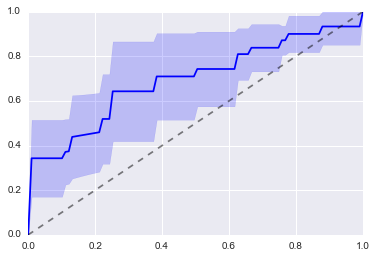

In [70]:
# Classify and print results
rf = RandomForestClassifier(n_estimators=1000)
results = cv_and_roc(rf, X, Y, random_state=random_state)

print(np.mean(results['auc_list']))
plot_auc_from_list(results['tpr_list'], results['mean_fpr'])
results['conf_mat']

#### Presence absence of BAL-gastric OTUs in BAL community

0.70496031746


,pred 0,pred 1
true 0,32,9
true 1,14,18


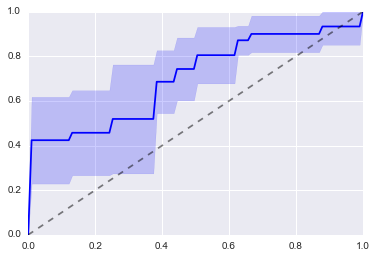

In [71]:
X_pres = (X > 0).astype(int)

rf = RandomForestClassifier(n_estimators=1000)
results_pres = cv_and_roc(rf, X_pres, Y, random_state=random_state)

print(np.mean(results_pres['auc_list']))
plot_auc_from_list(results_pres['tpr_list'], results_pres['mean_fpr'])
results_pres['conf_mat']

### Gastric community, gastric-BAL OTUs

In [72]:
# Get healthy and aspirators BAL samples
h_smpls = meta\
    .query('subject_id == @h_subjs')\
    .query('site == "gastric_fluid"')\
    .index.tolist()
asp_smpls = meta\
    .query('subject_id == @asp_subjs')\
    .query('site == "gastric_fluid"').index.tolist()

# Prepare data for classifiers
X = otu.loc[h_smpls + asp_smpls, :]
Y = [aspdict[meta.loc[i, 'mbs_consolidated']] for i in X.index]
X = X.values

0.685714285714


,pred 0,pred 1
true 0,28,13
true 1,17,15


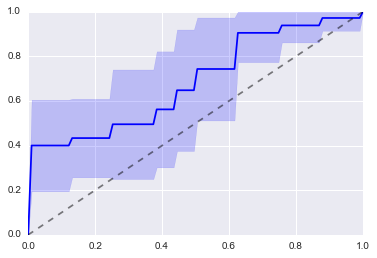

In [73]:
# Classify and print results
rf = RandomForestClassifier(n_estimators=1000)
results = cv_and_roc(rf, X, Y, random_state=random_state)

print(np.mean(results['auc_list']))
plot_auc_from_list(results['tpr_list'], results['mean_fpr'])
results['conf_mat']

#### Presence absence of BAL-gastric OTUs in gastric community


0.628968253968


,pred 0,pred 1
true 0,31,10
true 1,17,15


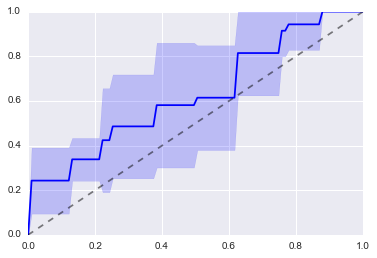

In [74]:
X_pres = (X > 0).astype(int)

rf = RandomForestClassifier(n_estimators=1000)
results_pres = cv_and_roc(rf, X_pres, Y, random_state=random_state)

print(np.mean(results_pres['auc_list']))
plot_auc_from_list(results_pres['tpr_list'], results_pres['mean_fpr'])
results_pres['conf_mat']

### BAL and gastric communities, BAL-gastric OTUs

In [75]:
mbscol = 'mbs_consolidated'
tidyotu = tidyfy_otu(otu, meta, mbscol)

site1 = 'bal'
site2 = 'gastric_fluid'
tmpotu = tidyotu.query('(site == @site1) | (site == @site2)')\
            .dropna(subset=[mbscol])\
            .pivot(index='subject_id', columns='otu_w_site',
                   values='abun')\
            .dropna()

Tidying data... 
Finished.


In [81]:
# Note: using how='inner' preserves the order of the left keys, so this new tmpmeta
# is in the same order as my OTU table
tmpmeta = pd.merge(tmpotu, meta[['subject_id', 'mbs_consolidated']].drop_duplicates(),  
                   left_index=True, right_on='subject_id',
                   how='inner')
X = tmpotu.values
Y = [aspdict[i] for i in tmpmeta['mbs_consolidated']]

In [124]:
tmpotu.index == tmpmeta['subject_id'].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True], dtype=bool)

0.700595238095


,pred 0,pred 1
true 0,30,11
true 1,16,16


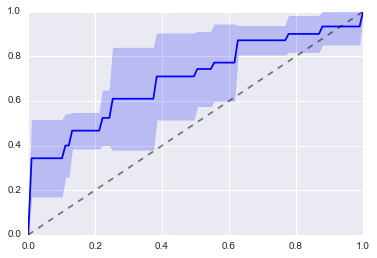

In [125]:
rf = RandomForestClassifier(n_estimators=1000)
results_pres = cv_and_roc(rf, X, Y, random_state=random_state)

print(np.mean(results_pres['auc_list']))
plot_auc_from_list(results_pres['tpr_list'], results_pres['mean_fpr'])
results_pres['conf_mat']

#### Presence/absence of BAL-gastric OTUs in both BAL and gastric communities

0.702777777778


,pred 0,pred 1
true 0,31,10
true 1,13,19


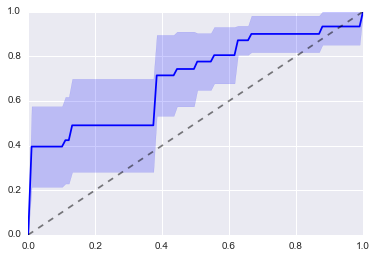

In [126]:
X_pres = (X > 0).astype(int)

rf = RandomForestClassifier(n_estimators=1000)
results_pres = cv_and_roc(rf, X_pres, Y, random_state=random_state)

print(np.mean(results_pres['auc_list']))
plot_auc_from_list(results_pres['tpr_list'], results_pres['mean_fpr'])
results_pres['conf_mat']